# **Predicting Hourly Energy Prices Using Time Series Analysis**

_By Isaac Valencia, Patrick de Beer, Cristina Ravenna, 
Mattias Escuerdo,and Matthew Henderson_
n


## Introduction and Motivation

background about energy markets. how does price tend to behave over time. what is important to look at when predicting energy price, etc. 

## Data Description

source and copy paste descriptions from kaggle here

Import Packages 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

import math
from sklearn.metrics import mean_squared_error

In [8]:
data = pd.read_csv('energy_dataset.csv')
data = pd.DataFrame(data)
data.head()


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [9]:
data.shape

(35064, 29)

In [10]:
def replace_whitespace_in_columns(data):
    data = data.copy()  # Avoid modifying the original dataframe directly
    data.columns = data.columns.str.replace(r'\s+', '_', regex=True)
    return data

data = replace_whitespace_in_columns(data)
data.columns

Index(['time', 'generation_biomass', 'generation_fossil_brown_coal/lignite',
       'generation_fossil_coal-derived_gas', 'generation_fossil_gas',
       'generation_fossil_hard_coal', 'generation_fossil_oil',
       'generation_fossil_oil_shale', 'generation_fossil_peat',
       'generation_geothermal', 'generation_hydro_pumped_storage_aggregated',
       'generation_hydro_pumped_storage_consumption',
       'generation_hydro_run-of-river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_marine',
       'generation_nuclear', 'generation_other', 'generation_other_renewable',
       'generation_solar', 'generation_waste', 'generation_wind_offshore',
       'generation_wind_onshore', 'forecast_solar_day_ahead',
       'forecast_wind_offshore_eday_ahead', 'forecast_wind_onshore_day_ahead',
       'total_load_forecast', 'total_load_actual', 'price_day_ahead',
       'price_actual'],
      dtype='object')

In [11]:
data_target = data.copy()
data_target['time'] = pd.to_datetime(data_target['time'], utc=True)
data_target.set_index('time', inplace=True)  # Set 'time' as the index
data_target = data_target[["price_actual", "price_day_ahead"]]
data_target

,price_actual,price_day_ahead
time,,
2014-12-31 23:00:00+00:00,65.41,50.10
2015-01-01 00:00:00+00:00,64.92,48.10
2015-01-01 01:00:00+00:00,64.48,47.33
2015-01-01 02:00:00+00:00,59.32,42.27
2015-01-01 03:00:00+00:00,56.04,38.41
...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85
2018-12-31 19:00:00+00:00,76.16,68.40
2018-12-31 20:00:00+00:00,74.30,66.88


In [12]:
data_target.describe()

,price_actual,price_day_ahead
count,35064.000000,35064.000000
mean,57.884023,49.874341
std,14.204083,14.618900
min,9.330000,2.060000
25%,49.347500,41.490000
50%,58.020000,50.520000
75%,68.010000,60.530000
max,116.800000,101.990000


In [13]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
generation_biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation_fossil_brown_coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation_fossil_coal-derived_gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation_fossil_gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation_fossil_hard_coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation_fossil_oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation_fossil_oil_shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation_fossil_peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation_geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation_hydro_pumped_storage_aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation_biomass                           35045 non-null  float64
 2   generation_fossil_brown_coal/lignite         35046 non-null  float64
 3   generation_fossil_coal-derived_gas           35046 non-null  float64
 4   generation_fossil_gas                        35046 non-null  float64
 5   generation_fossil_hard_coal                  35046 non-null  float64
 6   generation_fossil_oil                        35045 non-null  float64
 7   generation_fossil_oil_shale                  35046 non-null  float64
 8   generation_fossil_peat                       35046 non-null  float64
 9   generation_geothermal                        35046 non-null  float64
 10

## Exploratory Data Analysis

#### Assumptions

Time Series Setup

In [18]:
#the series will be used both in our EDA and later in the modeling process
#for now well keep it as a dataframe, as its easier to work with 
data['time'] = pd.to_datetime(data['time'], utc=True)

series = data[["time", "price_actual"]]
series.set_index('time', inplace=True)
series.head()

,price_actual
time,
2014-12-31 23:00:00+00:00,65.41
2015-01-01 00:00:00+00:00,64.92
2015-01-01 01:00:00+00:00,64.48
2015-01-01 02:00:00+00:00,59.32
2015-01-01 03:00:00+00:00,56.04


Frequency Check

In [20]:
# Inferred frequency outputs h, telling us that our data increments by hour
print("Inferred frequency:", pd.infer_freq(series.index))

# Between each time stamp we are increasing by exactly one hour
time_diffs = series.index.to_series().diff().value_counts().sort_index()
print("\nTime difference counts:")
print(time_diffs)

Inferred frequency: h

Time difference counts:
time
0 days 01:00:00    35063
Name: count, dtype: int64


Stationarity

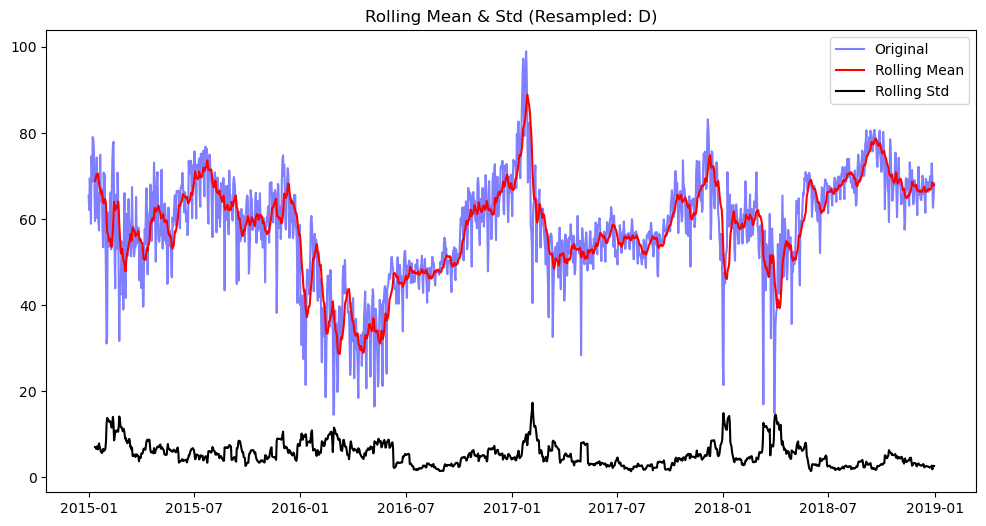

ADF Statistic: -2.8599582747810963
p-value: 0.05020637696917123
Critical Values:
	1%: -3.434908816804013
	5%: -2.863553406963303
	10%: -2.5678419239852994


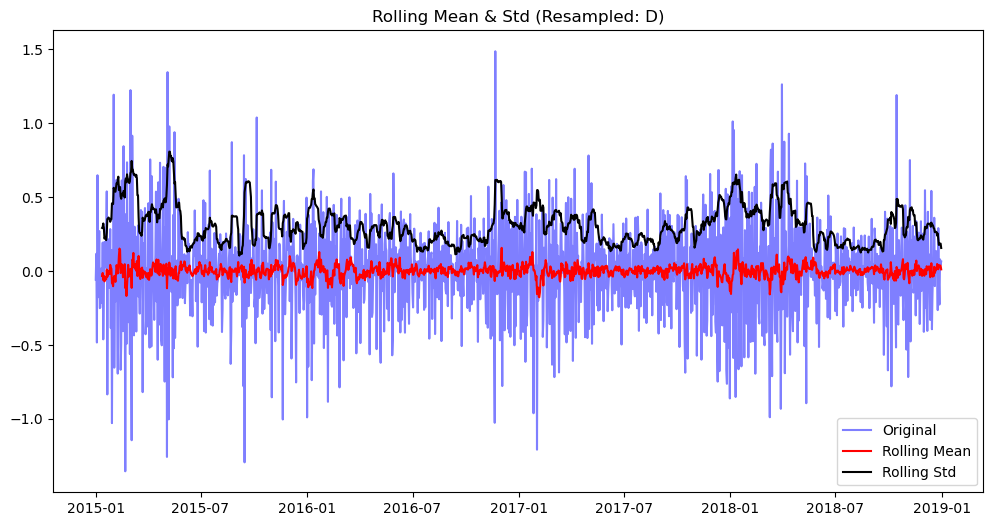

ADF Statistic: -13.70204216928502
p-value: 1.2842446089735298e-25
Critical Values:
	1%: -3.434889827343955
	5%: -2.863545026607168
	10%: -2.5678374612882515


In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

def get_stationarity(timeseries, window=12, resample_freq=None):
    """
    Check stationarity with rolling mean/std plots and ADF test.
    
    Parameters:
    - timeseries: pd.Series with a datetime index.
    - window: int, rolling window size.
    - resample_freq: str, pandas resampling rule (e.g., 'D', 'W', 'M').
    """
    # Optional resampling
    if resample_freq:
        timeseries = timeseries.resample(resample_freq).mean()

    # Rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original', alpha=0.5)
    plt.plot(rolling_mean, color='red', label='Rolling Mean', linewidth=1.5)
    plt.plot(rolling_std, color='black', label='Rolling Std', linewidth=1.5)
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Std (Resampled: {resample_freq})' if resample_freq else 'Rolling Mean & Std')
    plt.show()

    # ADF Test
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Downsample to daily frequency:
get_stationarity(series['price_actual'], window=12, resample_freq='D')
differenced_series = series.diff().dropna()
get_stationarity(differenced_series['price_actual'], window=12, resample_freq='D')


We're right at the cutoff for stationarity with p = .0502. Differencing the series removes trends and makes the data stationary, which is assumed in ARIMA models.

#### Exogenous Variable Analysis

Feature Selection

In [26]:
data.isna().sum()

time                                               0
generation_biomass                                19
generation_fossil_brown_coal/lignite              18
generation_fossil_coal-derived_gas                18
generation_fossil_gas                             18
generation_fossil_hard_coal                       18
generation_fossil_oil                             19
generation_fossil_oil_shale                       18
generation_fossil_peat                            18
generation_geothermal                             18
generation_hydro_pumped_storage_aggregated     35064
generation_hydro_pumped_storage_consumption       19
generation_hydro_run-of-river_and_poundage        19
generation_hydro_water_reservoir                  18
generation_marine                                 19
generation_nuclear                                17
generation_other                                  18
generation_other_renewable                        18
generation_solar                              

In [27]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time')

type(data)


# Loop over the columns of 'data' (not 'df')
for column in data.columns:
    # Step 1: Interpolate within the time series
    data[column] = data[column].interpolate(method='time')
    
    # Step 2: Fill any remaining gaps (like at the start)
    data[column] = data[column].fillna(method='bfill')

data = data.drop(columns = ['generation_hydro_pumped_storage_aggregated', 'forecast_wind_offshore_eday_ahead'])

In [28]:
data.corr()['price_actual']

generation_biomass                             0.142671
generation_fossil_brown_coal/lignite           0.363993
generation_fossil_coal-derived_gas                  NaN
generation_fossil_gas                          0.461452
generation_fossil_hard_coal                    0.465637
generation_fossil_oil                          0.285050
generation_fossil_oil_shale                         NaN
generation_fossil_peat                              NaN
generation_geothermal                               NaN
generation_hydro_pumped_storage_consumption   -0.426196
generation_hydro_run-of-river_and_poundage    -0.136659
generation_hydro_water_reservoir               0.071910
generation_marine                                   NaN
generation_nuclear                            -0.053016
generation_other                               0.099914
generation_other_renewable                     0.255551
generation_solar                               0.098529
generation_waste                               0

Predictors with missing correlation here are presumed constant and will be dropped.

In [30]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

exog_list = data.columns[:-2]

X = data[exog_list]
y = data['price_actual']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LassoCV(cv=5).fit(X_scaled, y)
print(pd.Series(model.coef_, index=exog_list))

generation_biomass                             0.000000
generation_fossil_brown_coal/lignite           0.000000
generation_fossil_coal-derived_gas             0.000000
generation_fossil_gas                          1.593574
generation_fossil_hard_coal                    2.731426
generation_fossil_oil                          0.000000
generation_fossil_oil_shale                    0.000000
generation_fossil_peat                         0.000000
generation_geothermal                          0.000000
generation_hydro_pumped_storage_consumption   -1.400102
generation_hydro_run-of-river_and_poundage    -0.000000
generation_hydro_water_reservoir               0.000000
generation_marine                              0.000000
generation_nuclear                            -0.000000
generation_other                               0.000000
generation_other_renewable                     0.631024
generation_solar                               0.000000
generation_waste                               0

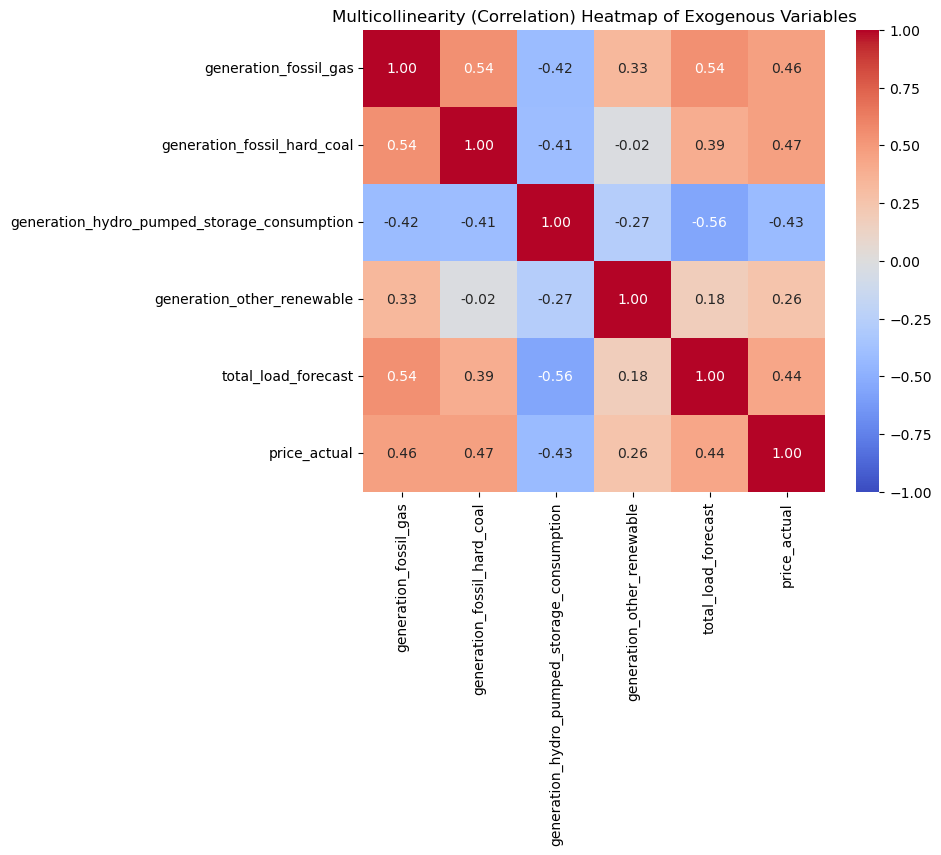

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

selection = [
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_hydro_pumped_storage_consumption',
    'generation_other_renewable',
    'total_load_forecast',
    'price_actual'
]

# Compute correlation matrix
corr_matrix = data[selection].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title('Multicollinearity (Correlation) Heatmap of Exogenous Variables')
plt.show()

In [32]:
data = data[selection]
data.head()

,generation_fossil_gas,generation_fossil_hard_coal,generation_hydro_pumped_storage_consumption,generation_other_renewable,total_load_forecast,price_actual
time,,,,,,
2014-12-31 23:00:00+00:00,4844.0,4821.0,863.0,73.0,26118.0,65.41
2015-01-01 00:00:00+00:00,5196.0,4755.0,920.0,71.0,24934.0,64.92
2015-01-01 01:00:00+00:00,4857.0,4581.0,1164.0,73.0,23515.0,64.48
2015-01-01 02:00:00+00:00,4314.0,4131.0,1503.0,75.0,22642.0,59.32
2015-01-01 03:00:00+00:00,4130.0,3840.0,1826.0,74.0,21785.0,56.04


Distribution, Trends

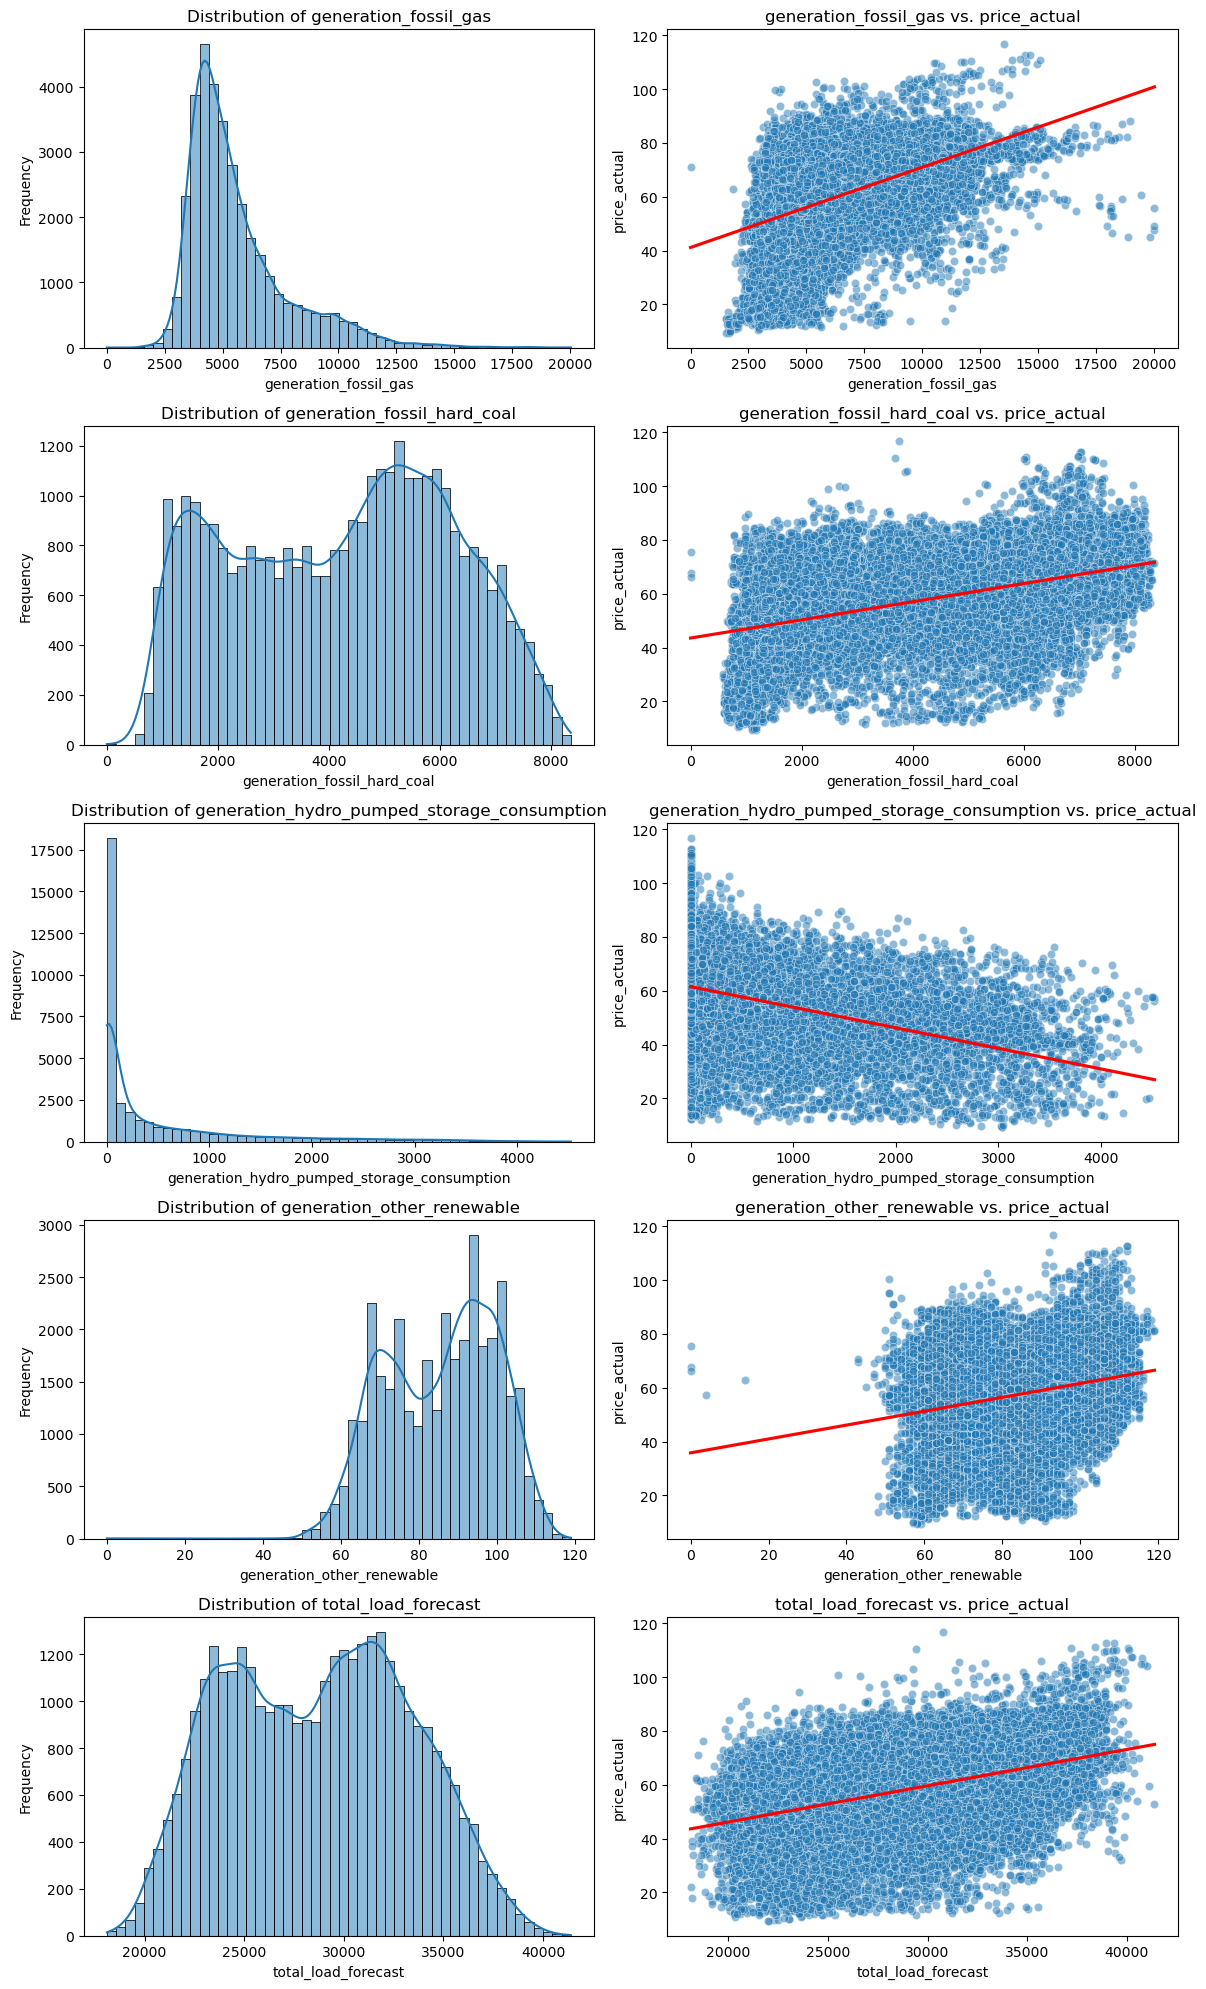

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of your selected exogenous variables
exog_list = [
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_hydro_pumped_storage_consumption',
    'generation_other_renewable',
    'total_load_forecast'
]

target = 'price_actual'  # Replace with your target variable name

# Set up the plot grid
n_cols = 2
n_rows = len(exog_list)

plt.figure(figsize=(12, 4 * n_rows))

for i, exog in enumerate(exog_list):
    # Plot distribution
    plt.subplot(n_rows, n_cols, 2*i + 1)
    sns.histplot(data[exog].dropna(), kde=True, bins=50)
    plt.title(f'Distribution of {exog}')
    plt.xlabel(exog)
    plt.ylabel('Frequency')

    # Plot relationship with the target
    plt.subplot(n_rows, n_cols, 2*i + 2)
    sns.scatterplot(x=data[exog], y=data[target], alpha=0.5)
    sns.regplot(x=data[exog], y=data[target], scatter=False, color='red', ci=None)  # Add trendline
    plt.title(f'{exog} vs. {target}')
    plt.xlabel(exog)
    plt.ylabel(target)

plt.tight_layout()
plt.show()


#### Target Variable Analysis

Seasonality

In [37]:
daily_data = series.resample('D').mean()
daily_data

,price_actual
time,
2014-12-31 00:00:00+00:00,65.410000
2015-01-01 00:00:00+00:00,62.090833
2015-01-02 00:00:00+00:00,69.443750
2015-01-03 00:00:00+00:00,65.223333
2015-01-04 00:00:00+00:00,58.912083
...,...
2018-12-27 00:00:00+00:00,72.959583
2018-12-28 00:00:00+00:00,69.230417
2018-12-29 00:00:00+00:00,62.623333


<Axes: xlabel='time'>

<Figure size 2000x1000 with 0 Axes>

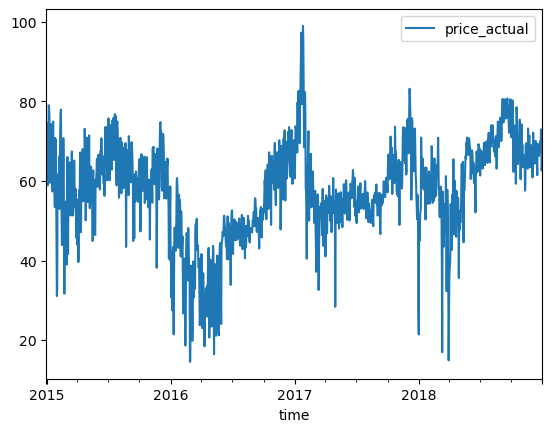

In [38]:
plt.figure(figsize=(20, 10))
daily_data.plot()

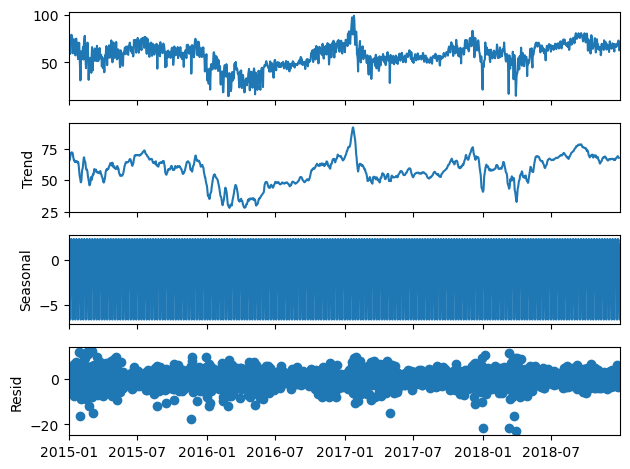

In [39]:
seasonal_decompose(daily_data, model='additive').plot()
plt.show()

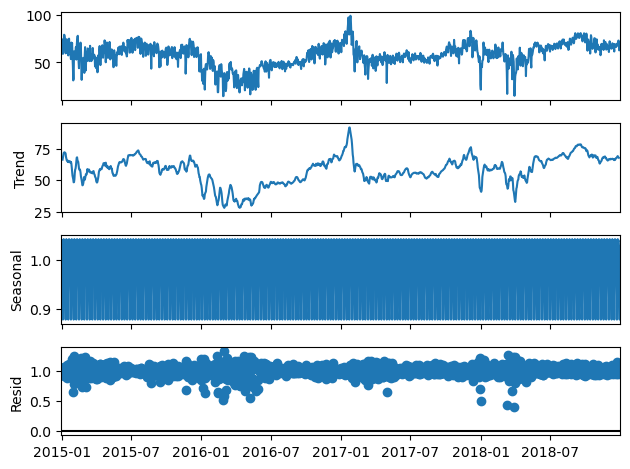

In [40]:
seasonal_decompose(daily_data, model='multiplative').plot()
plt.show()

Distribution of Response Variable

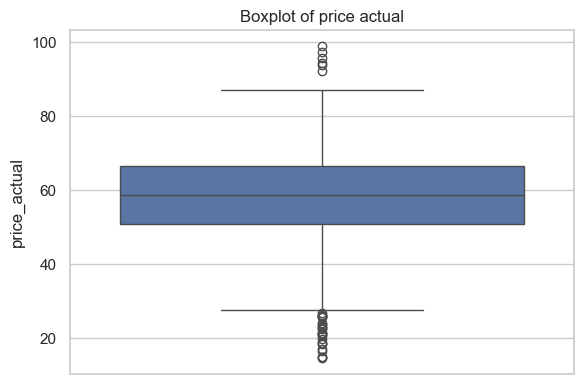

In [42]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.boxplot(y=daily_data['price_actual'])
plt.title(f'Boxplot of price actual')
plt.tight_layout()
plt.show()

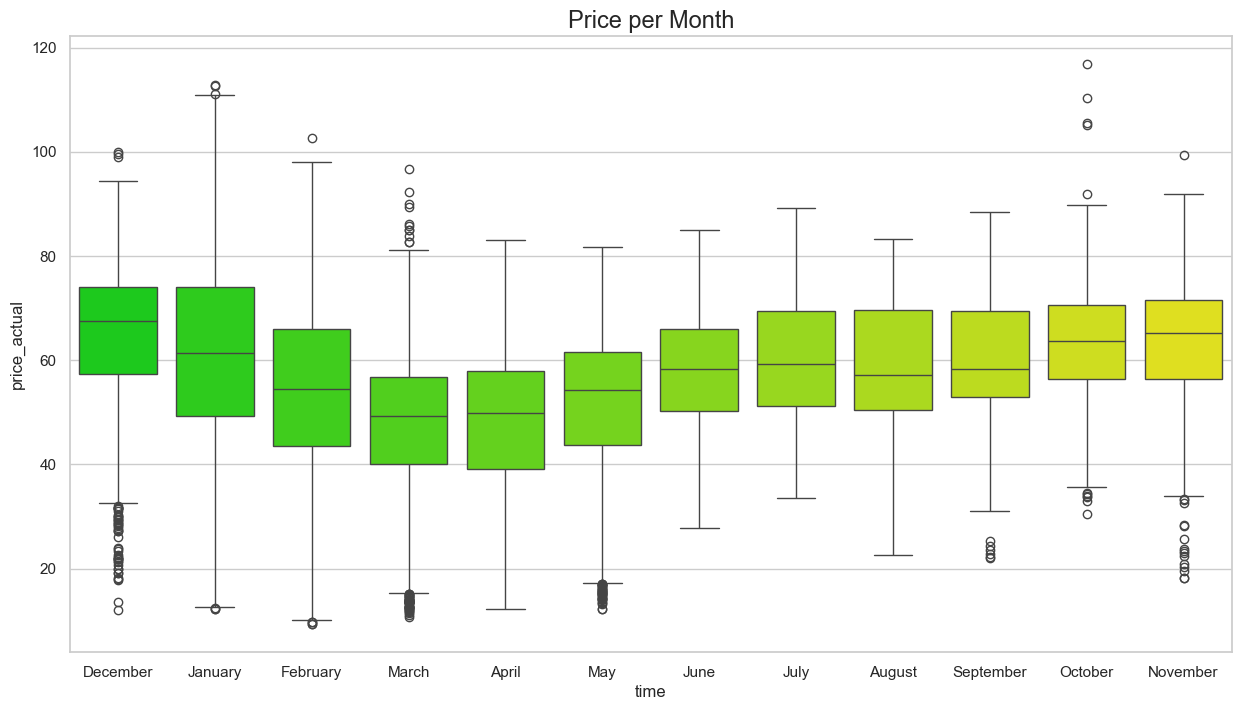

In [43]:
plt.figure(figsize=(15, 8))

sns.boxplot(x = series.index.month_name(), y = series['price_actual'], data=series, hue=series.index.month_name(), palette = sns.color_palette("blend:#00e600,#ffff00", 12) , legend=False);
plt.title('Price per Month', fontsize=17);

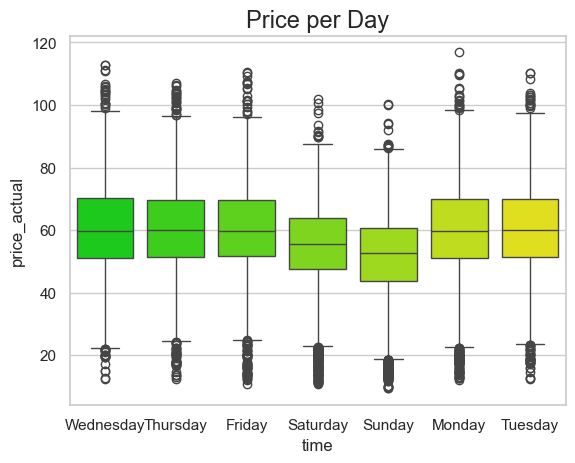

In [44]:
sns.boxplot(x = series.index.day_name(), y = series['price_actual'], data=series, hue=series.index.day_name(), palette = sns.color_palette("blend:#00e600,#ffff00", 7) , legend=False);
plt.title('Price per Day', fontsize=17);

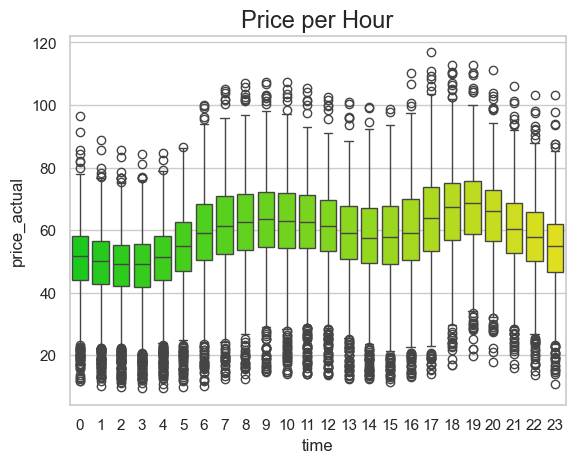

In [45]:
sns.boxplot(x = series.index.hour, y = series['price_actual'], data=series, hue=series.index.hour, palette = sns.color_palette("blend:#00e600,#ffff00", 24) , legend=False);
plt.title('Price per Hour', fontsize=17);

## Preliminary Models

Seasonal Naive Model

In [48]:
series = series['price_actual']  
series #series well use for naive and arima 

time
2014-12-31 23:00:00+00:00    65.41
2015-01-01 00:00:00+00:00    64.92
2015-01-01 01:00:00+00:00    64.48
2015-01-01 02:00:00+00:00    59.32
2015-01-01 03:00:00+00:00    56.04
                             ...  
2018-12-31 18:00:00+00:00    77.02
2018-12-31 19:00:00+00:00    76.16
2018-12-31 20:00:00+00:00    74.30
2018-12-31 21:00:00+00:00    69.89
2018-12-31 22:00:00+00:00    69.88
Name: price_actual, Length: 35064, dtype: float64

In [49]:
data_target['naive_seasonal_forecast'] = data_target['price_actual'].shift(24)
data_target

,price_actual,price_day_ahead,naive_seasonal_forecast
time,,,
2014-12-31 23:00:00+00:00,65.41,50.10,NaN
2015-01-01 00:00:00+00:00,64.92,48.10,NaN
2015-01-01 01:00:00+00:00,64.48,47.33,NaN
2015-01-01 02:00:00+00:00,59.32,42.27,NaN
2015-01-01 03:00:00+00:00,56.04,38.41,NaN
...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,72.37
2018-12-31 19:00:00+00:00,76.16,68.40,73.35
2018-12-31 20:00:00+00:00,74.30,66.88,73.64


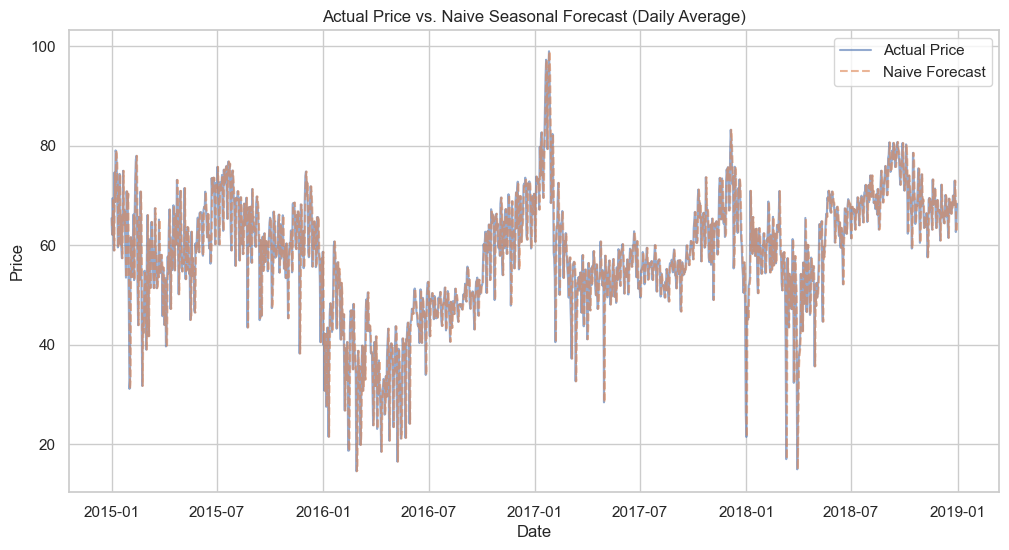

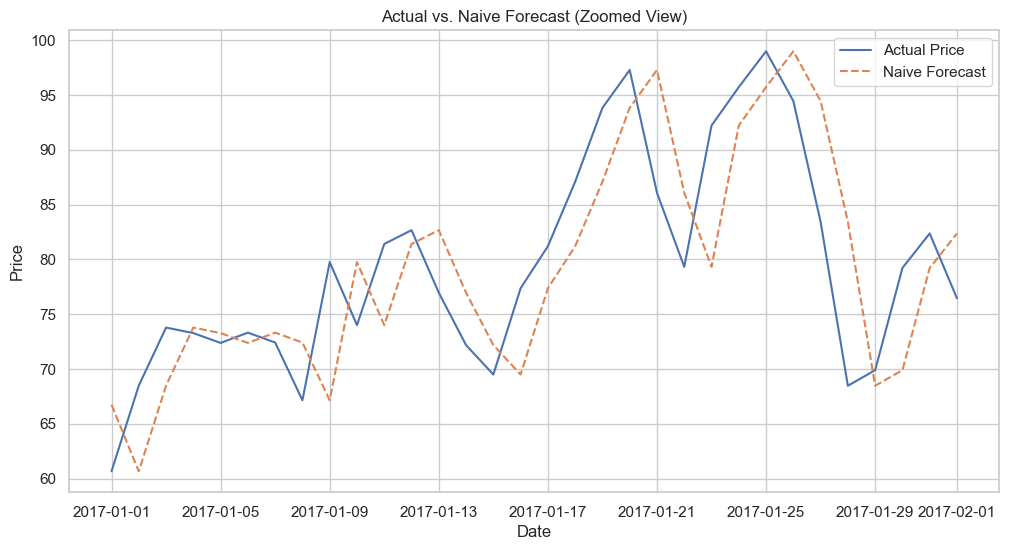

In [50]:
import matplotlib.pyplot as plt

# Create a resampled copy for display only (daily averages)
plot_data = data_target.resample('D').mean()
plot_data

# Plot the daily-averaged actual vs naive seasonal forecast
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['price_actual'], label='Actual Price', alpha=0.6, linewidth=1.5)
plt.plot(plot_data.index, plot_data['naive_seasonal_forecast'], label='Naive Forecast', alpha=0.6, linewidth=1.5, linestyle='--')
plt.title('Actual Price vs. Naive Seasonal Forecast (Daily Average)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


zoomed_data = plot_data.loc['2017-01-01':'2017-02-01']  # Adjust dates to your data

plt.figure(figsize=(12, 6))
plt.plot(zoomed_data.index, zoomed_data['price_actual'], label='Actual Price')
plt.plot(zoomed_data.index, zoomed_data['naive_seasonal_forecast'], label='Naive Forecast', linestyle='--')
plt.title('Actual vs. Naive Forecast (Zoomed View)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


def evaluate_forecast(actual, forecast):
    valid = pd.concat([actual, forecast], axis=1).dropna()
    actual_values = valid.iloc[:, 0]
    forecast_values = valid.iloc[:, 1]
    
    mae = mean_absolute_error(actual_values, forecast_values)
    rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Example usage:
metrics = evaluate_forecast(data_target['price_actual'], data_target['naive_seasonal_forecast'])
print(metrics)



{'MAE': 5.796815068493149, 'RMSE': 8.31192688036967, 'MAPE': 11.756059222301882}


ARIMA

In [ ]:
SARIMAX

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np

# Assuming 'series' is your stationary time series (no manual differencing needed because d=1)
X = series[-1200:]

# Train-test split (90% train)
size = int(len(X) * 0.9)
train, test = X[0:size], X[size:]

history = list(train)  # List for walk-forward appending
predictions = []

# Walk-forward validation (build model at each step)
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 1))  # Example ARIMA config
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    obs = test.iloc[t]
    history.append(obs)
    print(f'predicted={yhat:.4f}, expected={obs:.4f}')

# Create a Series of predictions with the test index
pred_series = pd.Series(predictions, index=test.index)


## Final Model

In [ ]:
Ensemble

In [ ]:
def evaluate_forecast(actual, forecast):
    valid = pd.concat([actual, forecast], axis=1).dropna()
    actual_values = valid.iloc[:, 0]
    forecast_values = valid.iloc[:, 1]
    
    mae = mean_absolute_error(actual_values, forecast_values)
    rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Example usage:
metrics = evaluate_forecast(data_target['price_actual'], data_target['price_day_ahead'])
print(metrics)